In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms

In [2]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True,
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:03<00:00, 3.06MB/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 225kB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.06MB/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.48MB/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



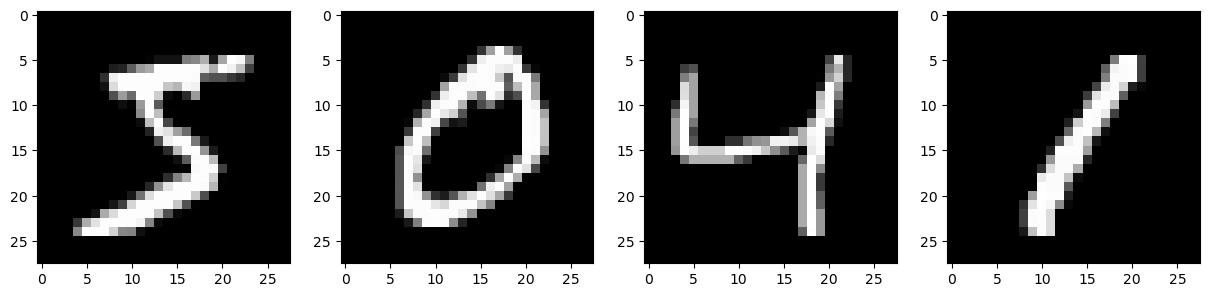

In [4]:
fig, gs = plt.figure(figsize=(15,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

### Полносвязная нейронная сеть (Персептрон)
![](./imgs/image.png?raw=1)

Перепишем в матричном виде:
$$
f(\mathbf{x}, \mathbf{W}) = \mathbf{W}_{n_2+1}\sigma\bigr( \cdots\mathbf{W}_2\sigma\bigr(\mathbf{W}_{1}\mathbf{x}\bigr)\cdots\bigr)
$$

- число $n$ --- размерность пространства признаков (`input_dim`);
- число $n_1$ --- размерность скрытого слоя (`hidden_dim`);
- число $n_2$ --- количество скрытых слоев (`num_layers`);
- число $n_3$ --- размерность пространства ответов (`output_dim`).

In [5]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0,
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim

        self.layers.add_module('classifier',
                               torch.nn.Linear(prev_size, output_dim))

    def forward(self, input):
        return self.layers(input)

In [7]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in generator:
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [8]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
                                                shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()


In [9]:
def draw_table(data, title=['ACCURACY'], width=[60, 11]):
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'

    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 2],
                      'hidden_dim': [8, 64],
                      'p': [0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [11]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'])
        model.to(device)
        _ = model.train()
        trainer(model=model,
                dataset=traindata,
                loss_function=torch.nn.CrossEntropyLoss(),
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']),
                epochs=4)

        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matalhim/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [12]:
draw_table(scores)

+------------------------------------------------------------+-----------+
|                                                            |   ACCURACY|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|       0.92|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|       0.91|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}|       0.82|
+------------------------------------------------------------+-----------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}|       0.47|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|       0.92|
+------------------------------------------------------------+-----------+
|  {'hidden_dim': 64, 'lr